In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-dataset-homeqoute/test/test.csv
/kaggle/input/train-home-qoute-dataset/train/train.csv


In [2]:
# Step 1: Import libraries and initialize Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, lit, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("HomeQuoteClassification") \
    .getOrCreate()

# Confirm Spark is working
spark.version


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 15:33:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.5.5'

In [3]:
# Load the training data
train_path = "/kaggle/input/train-home-qoute-dataset/train/train.csv"
test_path = "/kaggle/input/test-dataset-homeqoute/test/test.csv"

# Read CSV into Spark DataFrames
df_train = spark.read.csv(train_path, header=True, inferSchema=True)
df_test = spark.read.csv(test_path, header=True, inferSchema=True)

# Show schema and first few rows
df_train.printSchema()
df_train.show(5)

df_test.printSchema()
df_test.show(5)



root
 |-- QuoteNumber: integer (nullable = true)
 |-- Original_Quote_Date: date (nullable = true)
 |-- QuoteConversion_Flag: integer (nullable = true)
 |-- Field6: string (nullable = true)
 |-- Field7: integer (nullable = true)
 |-- Field8: double (nullable = true)
 |-- Field9: double (nullable = true)
 |-- Field10: string (nullable = true)
 |-- Field11: double (nullable = true)
 |-- Field12: string (nullable = true)
 |-- CoverageField1A: integer (nullable = true)
 |-- CoverageField1B: integer (nullable = true)
 |-- CoverageField2A: integer (nullable = true)
 |-- CoverageField2B: integer (nullable = true)
 |-- CoverageField3A: integer (nullable = true)
 |-- CoverageField3B: integer (nullable = true)
 |-- CoverageField4A: integer (nullable = true)
 |-- CoverageField4B: integer (nullable = true)
 |-- CoverageField5A: integer (nullable = true)
 |-- CoverageField5B: integer (nullable = true)
 |-- CoverageField6A: integer (nullable = true)
 |-- CoverageField6B: integer (nullable = true)
 |-

25/06/17 15:33:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+-------------------+--------------------+------+------+------+------+-------+-------+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+----------------+----------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+-------------

In [4]:
# Rename target and ID columns in train and test datasets
df_train = df_train.withColumnRenamed("QuoteConversion_Flag", "label") \
                   .withColumnRenamed("QuoteNumber", "Id")

df_test = df_test.withColumnRenamed("QuoteNumber", "Id")

# Drop unused date column if it exists
if "Original_Quote_Date" in df_train.columns:
    df_train = df_train.drop("Original_Quote_Date")
if "Original_Quote_Date" in df_test.columns:
    df_test = df_test.drop("Original_Quote_Date")

# Confirm changes
df_train.select("Id", "label").show(5)


+---+-----+
| Id|label|
+---+-----+
|  1|    0|
|  2|    0|
|  4|    0|
|  6|    0|
|  8|    0|
+---+-----+
only showing top 5 rows



## Train

In [5]:
from pyspark.sql.functions import count, col, when, isnan

# Step 4.1: Identify missing values in df_train
missing_train = df_train.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c)
    for c in df_train.columns
])

missing_train.show()


+---+-----+------+------+------+------+-------+-------+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+----------------+----------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------

In [6]:
from pyspark.sql.functions import count, when, col

# Total number of rows
total_rows = df_train.count()

# Compute % missing for each column
missing_percent = df_train.select([
    (count(when(col(c).isNull() | isnan(c), c)) / total_rows * 100).alias(c)
    for c in df_train.columns
])

# Transpose and display nicely
missing_df = (
    missing_percent.toPandas()
    .T
    .reset_index()
    .rename(columns={"index": "Column", 0: "% Missing"})
    .sort_values(by="% Missing", ascending=False)
)

import pandas as pd
pd.set_option("display.max_rows", None)  # Show all rows
missing_df


,Column,% Missing
160,PropertyField29,76.963640
124,PersonalField84,47.634351
169,PropertyField38,0.467876
48,PersonalField7,0.043336
167,PropertyField36,0.043336
129,PropertyField3,0.031064
165,PropertyField34,0.026845
163,PropertyField32,0.026845
130,PropertyField4,0.024161
203,GeographicField16B,0.000000


In [7]:
# Drop column with excessive missing values
df_train = df_train.drop("PropertyField29")
df_train = df_train.drop("PersonalField84")


In [8]:
# Reload with inferSchema explicitly enabled
df_train = spark.read.option("header", True).option("inferSchema", True).csv(train_path)
df_test = spark.read.option("header", True).option("inferSchema", True).csv(test_path)

# Drop 'Original_Quote_Date' and rename again
df_train = df_train.withColumnRenamed("QuoteConversion_Flag", "label") \
                   .withColumnRenamed("QuoteNumber", "Id") \
                   .drop("Original_Quote_Date")

df_test = df_test.withColumnRenamed("QuoteNumber", "Id") \
                 .drop("Original_Quote_Date")


In [9]:
# Identify categorical and numeric columns
cat_cols = [f.name for f in df_train.schema.fields if str(f.dataType) == "StringType" and f.name != "label"]
num_cols = [f.name for f in df_train.schema.fields if str(f.dataType) in ["DoubleType", "IntegerType"] and f.name not in ["label", "Id"]]

print("Categorical columns:", cat_cols[:5], "...")  # just sample
print("Numerical columns:", num_cols[:5], "...")


Categorical columns: [] ...
Numerical columns: [] ...


In [10]:
sample_df = df_train.limit(5000).toPandas()

# Try converting each column to numeric — if most values work, assume it's numeric
numeric_guess = []
categorical_guess = []

for col in sample_df.columns:
    try:
        sample_df[col].astype(float)
        numeric_guess.append(col)
    except:
        categorical_guess.append(col)

# Remove label and Id manually
numeric_guess = [c for c in numeric_guess if c not in ["label", "Id"]]
categorical_guess = [c for c in categorical_guess if c not in ["label", "Id"]]

print("Likely numeric columns:", numeric_guess[:5])
print("Likely categorical columns:", categorical_guess[:5])


Likely numeric columns: ['Field7', 'Field8', 'Field9', 'Field11', 'CoverageField1A']
Likely categorical columns: ['Field6', 'Field10', 'Field12', 'CoverageField8', 'CoverageField9']


## Impute Numeric with Mean

In [11]:
from pyspark.sql.functions import avg

for col_name in numeric_guess:
    mean_val = df_train.select(avg(col_name)).first()[0]
    if mean_val is not None:
        df_train = df_train.fillna({col_name: mean_val})


## Impute Categorical with Mode

In [12]:
from pyspark.sql.functions import col, count

for col_name in categorical_guess:
    mode_row = df_train.groupBy(col_name).count().orderBy('count', ascending=False).first()
    if mode_row is not None:
        mode_val = mode_row[0]
        df_train = df_train.fillna({col_name: mode_val})


## Align Categorical Columns Between Train and Test

In [13]:
# Get a quick guess of categorical columns again
sample_df = df_train.limit(5000).toPandas()

categorical_guess = []
for col in sample_df.columns:
    try:
        sample_df[col].astype(float)
    except:
        if col not in ['label', 'Id']:
            categorical_guess.append(col)

print("Categorical columns:", categorical_guess[:5])


Categorical columns: ['Field6', 'Field10', 'Field12', 'CoverageField8', 'CoverageField9']


In [14]:
from pyspark.sql.functions import when, col, lit

for col_name in categorical_guess:
    # Get unique categories
    train_values = df_train.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()
    test_values = df_test.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()

    unseen_in_train = list(set(test_values) - set(train_values))

    if unseen_in_train:
        # Get mode
        mode_row = df_train.groupBy(col_name).count().orderBy('count', ascending=False).first()
        if mode_row:
            mode_value = mode_row[0]

            # Replace each unseen category manually
            condition = col(col_name).isin(unseen_in_train)
            df_test = df_test.withColumn(
                col_name,
                when(condition, lit(mode_value)).otherwise(col(col_name))
            )

        print(f"Replaced unseen categories in '{col_name}':", unseen_in_train)


Replaced unseen categories in 'PersonalField7': [None]


Replaced unseen categories in 'PersonalField16': ['YG', 'ZM', 'XG']


Replaced unseen categories in 'PersonalField17': ['XZ', 'XF', 'YO', 'ZJ']


Replaced unseen categories in 'PersonalField18': ['XB']


Replaced unseen categories in 'PersonalField19': ['ZS']


Replaced unseen categories in 'PropertyField3': [None]


Replaced unseen categories in 'PropertyField4': [None]


Replaced unseen categories in 'PropertyField5': [None]


Replaced unseen categories in 'PropertyField7': ['T']


Replaced unseen categories in 'PropertyField30': [None]


Replaced unseen categories in 'PropertyField32': [None]


Replaced unseen categories in 'PropertyField34': [None]


Replaced unseen categories in 'PropertyField36': [None]


Replaced unseen categories in 'PropertyField37': [' ']


Replaced unseen categories in 'PropertyField38': [None]


## Index Categorical Columns

In [15]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
    for col in categorical_guess
]


## Assemble Features into a Vector

In [16]:
from pyspark.ml.feature import VectorAssembler

# Combine numeric and indexed categorical columns
feature_cols = numeric_guess + [f"{col}_indexed" for col in categorical_guess]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)


## Build and Apply the Pipeline

In [17]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(df_train)

df_train_prepped = pipeline_model.transform(df_train)
df_test_prepped = pipeline_model.transform(df_test)



## Split Train Data into Train/Test Subset

In [18]:
train_split, val_split = df_train_prepped.randomSplit([0.7, 0.3], seed=42)



##  Train a Logistic Regression Model

In [19]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_split)


25/06/17 15:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1016.5 KiB
25/06/17 15:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:28 WARN MemoryStore: Not enough space to cache rdd_3137_0 in memory! (computed 65.1 MiB so far)
25/06/17 15:48:28 WARN BlockManager: Persisting block rdd_3137_0 to disk instead.
25/06/17 15:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/17 15:48:33 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
25/06/

## Make Predictions and Evaluate

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predict on validation split
val_pred = lr_model.transform(val_split)

# Accuracy
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = acc_eval.evaluate(val_pred)

# AUC
auc_eval = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = auc_eval.evaluate(val_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation AUC: {auc:.4f}")


25/06/17 15:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
25/06/17 15:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB


Validation Accuracy: 0.9150
Validation AUC: 0.9415


## Random Forest Classifier

In [21]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxBins=128)
rf_model = rf.fit(train_split)


rf_pred = rf_model.transform(val_split)

# Evaluation
rf_accuracy = acc_eval.evaluate(rf_pred)
rf_auc = auc_eval.evaluate(rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")


25/06/17 15:51:02 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
25/06/17 15:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1012.7 KiB
25/06/17 15:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
25/06/17 15:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1070.7 KiB
25/06/17 15:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB
25/06/17 15:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1180.0 KiB
25/06/17 15:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB
25/06/17 15:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1580.2 KiB
25/06/17 15:53:10 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB
25/06/17 15:53:42 WARN DAGScheduler: Broadcasting large task binary with size 1425.3 KiB


Random Forest Accuracy: 0.8298
Random Forest AUC: 0.9074


## Gradient Boosting

In [22]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100, maxBins=128)
gbt_model = gbt.fit(train_split)


gbt_pred = gbt_model.transform(val_split)

# Evaluation
gbt_accuracy = acc_eval.evaluate(gbt_pred)
gbt_auc = auc_eval.evaluate(gbt_pred)

print(f"Gradient Boosting Accuracy: {gbt_accuracy:.4f}")
print(f"Gradient Boosting AUC: {gbt_auc:.4f}")



25/06/17 15:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
25/06/17 15:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
25/06/17 15:55:00 WARN DAGScheduler: Broadcasting large task binary with size 1018.9 KiB
25/06/17 15:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1055.0 KiB
25/06/17 15:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
25/06/17 15:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
25/06/17 15:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1058.5 KiB
25/06/17 15:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1060.8 KiB
25/06/17 15:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.5 KiB
25/06/17 15:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1069.1 KiB
25/06/17 15:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1069.7 KiB
25/06/17 15:55:59 WAR

Gradient Boosting Accuracy: 0.9240
Gradient Boosting AUC: 0.9613


In [23]:
# Predict on test data
final_pred = gbt_model.transform(df_test_prepped)

# Select Id and prediction, cast to int
submission = final_pred.select("Id", final_pred["prediction"].cast("int").alias("label"))


25/06/17 16:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
25/06/17 16:00:59 WARN DAGScheduler: Broadcasting large task binary with size 1423.4 KiB
25/06/17 16:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1959.3 KiB


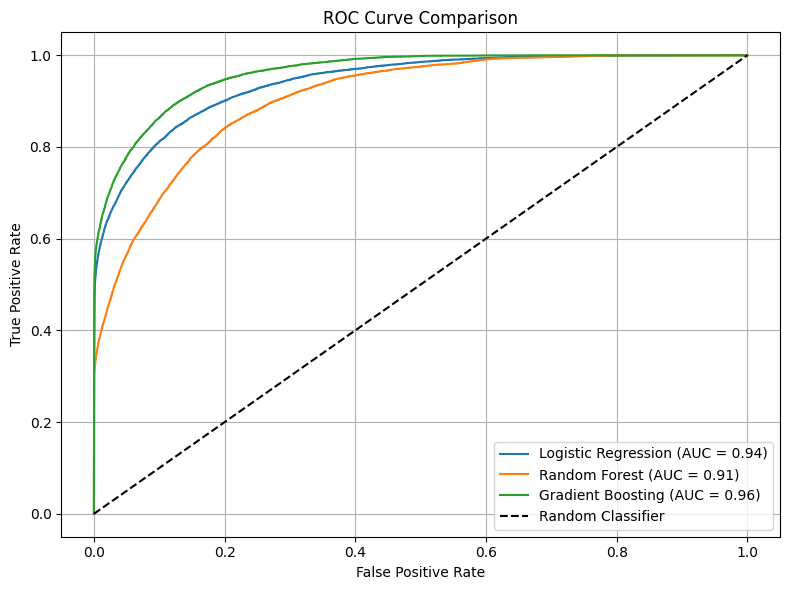

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def get_roc_data(pred_df):
    # Extract raw prediction and label
    score_and_label = pred_df.select("rawPrediction", "label").rdd.map(lambda row: (float(row[0][1]), float(row[1])))
    scores, labels = zip(*score_and_label.collect())
    return scores, labels

# Get prediction scores
lr_scores, lr_labels = get_roc_data(val_pred)
rf_scores, rf_labels = get_roc_data(rf_pred)
gbt_scores, gbt_labels = get_roc_data(gbt_pred)

# Compute FPR, TPR, and AUC
fpr_lr, tpr_lr, _ = roc_curve(lr_labels, lr_scores)
fpr_rf, tpr_rf, _ = roc_curve(rf_labels, rf_scores)
fpr_gbt, tpr_gbt, _ = roc_curve(gbt_labels, gbt_scores)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_gbt = auc(fpr_gbt, tpr_gbt)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_gbt, tpr_gbt, label=f"Gradient Boosting (AUC = {auc_gbt:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


25/06/17 16:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
25/06/17 16:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1508.4 KiB
25/06/17 16:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1508.2 KiB
25/06/17 16:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1505.8 KiB
25/06/17 16:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB
25/06/17 16:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1525.8 KiB
25/06/17 16:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1528.5 KiB
25/06/17 16:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
25/06/17 16:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1508.4 KiB
25/06/17 16:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1508.2 KiB
25/06/17 16:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1505.8 KiB
25/06/17 16:03:39 WAR

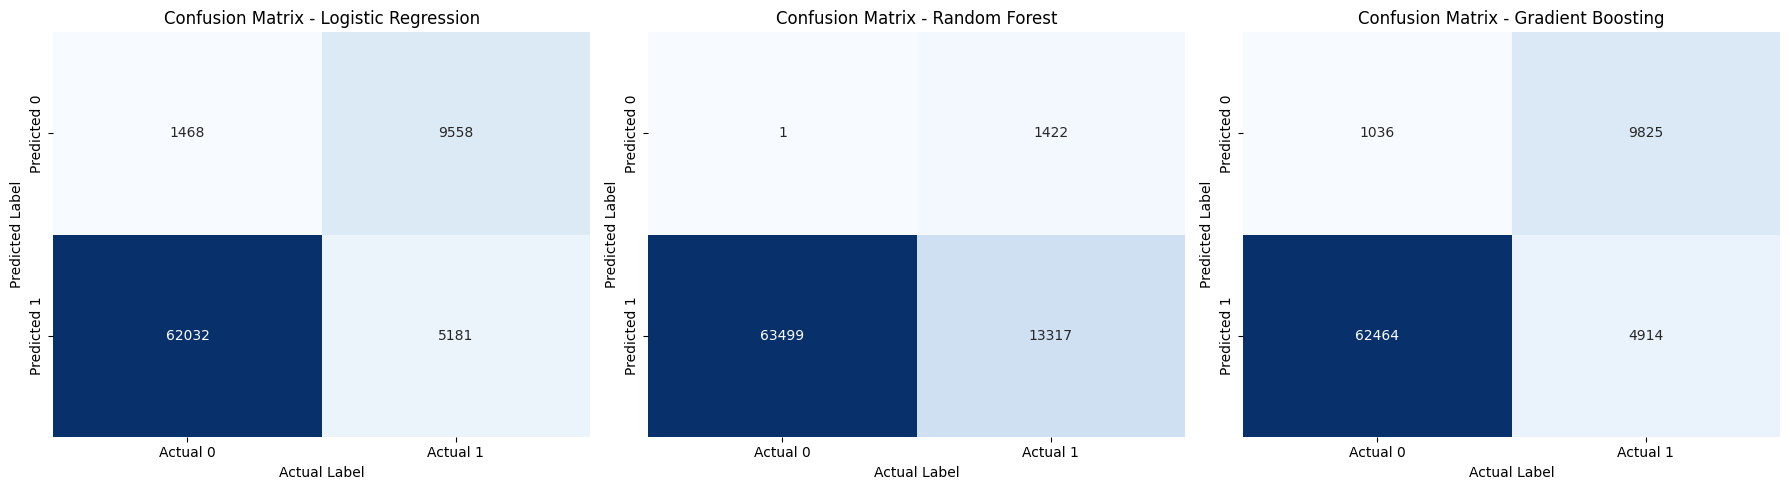

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_confusion_matrix(pred_df):
    cm = pred_df.crosstab("prediction", "label").toPandas()
    cm.columns.name = None
    cm.set_index("prediction_label", inplace=True)
    cm = cm.astype(int)
    cm.index = ['Predicted 0', 'Predicted 1']
    cm.columns = ['Actual 0', 'Actual 1']
    return cm

# Get confusion matrices from your validation predictions
cm_lr = get_confusion_matrix(val_pred)
cm_rf = get_confusion_matrix(rf_pred)
cm_gbt = get_confusion_matrix(gbt_pred)

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm, title in zip(axes, [cm_lr, cm_rf, cm_gbt], 
                         ['Logistic Regression', 'Random Forest', 'Gradient Boosting']):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel("Actual Label")
    ax.set_ylabel("Predicted Label")
    ax.set_title(f"Confusion Matrix - {title}")

plt.tight_layout()
plt.show()


In [26]:
# Predict on test data
final_pred = gbt_model.transform(df_test_prepped)

# Select Id and prediction, cast to int
submission = final_pred.select("Id", final_pred["prediction"].cast("int").alias("label"))


In [27]:
final_pred.select("Id", "prediction", "probability").show(10, truncate=False)


25/06/17 16:05:14 WARN DAGScheduler: Broadcasting large task binary with size 1361.7 KiB


+---+----------+-----------------------------------------+
|Id |prediction|probability                              |
+---+----------+-----------------------------------------+
|15 |0.0       |[0.9843125139048121,0.015687486095187886]|
|17 |0.0       |[0.9877437281288435,0.012256271871156521]|
|27 |0.0       |[0.9832233816161776,0.016776618383822384]|
|39 |0.0       |[0.9856157051791763,0.014384294820823706]|
|60 |0.0       |[0.9849870704222649,0.015012929577735146]|
|68 |0.0       |[0.9874752816079747,0.012524718392025291]|
|122|0.0       |[0.984096216081132,0.015903783918868042] |
|130|0.0       |[0.9684467268184649,0.03155327318153511] |
|159|0.0       |[0.9868991775386469,0.013100822461353134]|
|160|0.0       |[0.9594258581371169,0.040574141862883106]|
+---+----------+-----------------------------------------+
only showing top 10 rows



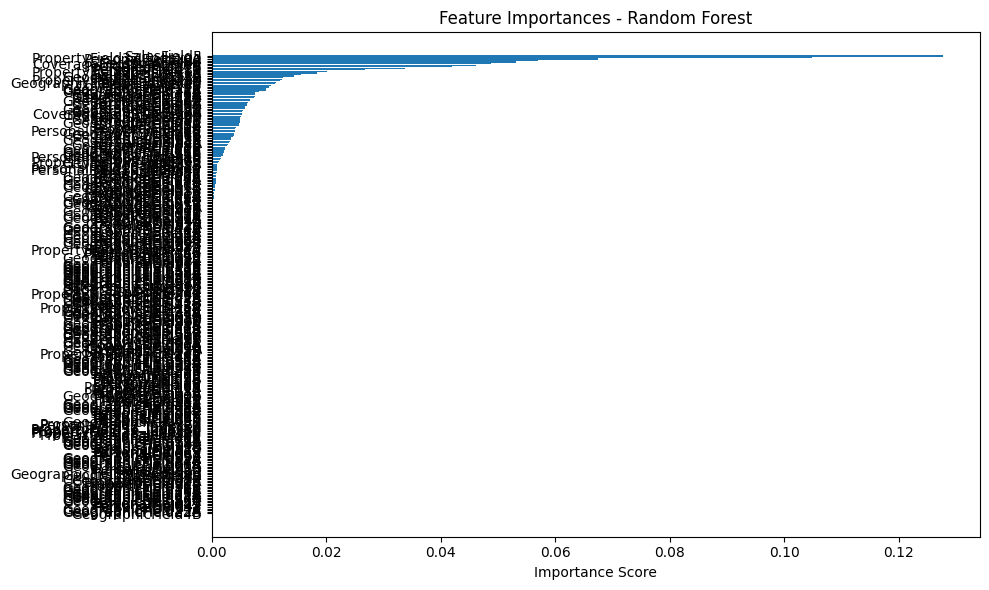

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have a trained RF or GBT model and your final feature vector assembler
# Example: `rf_model` and `assembler`

# Get feature importances from model
importances = rf_model.featureImportances

# Get input feature names from assembler
feature_names = assembler.getInputCols()

# Pair feature names with their importance scores
importance_list = list(zip(feature_names, importances.toArray()))

# Convert to Pandas DataFrame for sorting and plotting
importance_df = pd.DataFrame(importance_list, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.title("Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
